In [157]:
# from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import time 
import os
import math
import random

In [158]:
MAX_SEQ_LENGTH = 55
NUM_FEATURES = 512
IMG_SIZE = 128
EPOCHS = 20

In [159]:
dataset_path = "dataset"
train=pd.DataFrame(columns=['video_name','tag'])
test=pd.DataFrame(columns=['video_name','tag'])

print(train)
j = 0
for root, files, videos in os.walk(dataset_path):

    class_name = root.split("/")
#     if j>=5:
#         break
    if len(class_name)>1:
        j += 1
        thresh = math.ceil(len(videos)*0.8)
        random.shuffle(videos)
        print("root---",root,videos)
        
        for i,  video in enumerate(videos) :
            if i <= thresh:
                train=train.append({"video_name":os.path.join(class_name[-1],video),"tag":class_name[-1]},ignore_index = True)
            else:
                test=test.append({"video_name":os.path.join(class_name[-1],video),"tag":class_name[-1]},ignore_index = True)
#     for video in videos[thresh:]:
            
   

print(train.head())
print(test.head())
train.to_csv('train_transfromer_new3.csv')   
test.to_csv('test_transfromer_new3.csv')

Empty DataFrame
Columns: [video_name, tag]
Index: []
root--- dataset/चक्लेत् ['chocolate (20).mp4', 'chocolate (5).mp4', 'chocolate (28).mp4', 'chocolate (19).mp4', 'chocolate (21).mp4', 'chocolate (11).mp4', 'chocolate (14)new.mp4', 'chocolate (35).mp4', 'chocolate (30).mp4', 'chocolate (15)new.mp4', 'chocolate (42).mp4', 'chocolate (4).mp4', 'chocolate (27).mp4', 'chocolate (36).mp4', 'chocolate (16).mp4', 'chocolate (19)new.mp4', 'chocolate (48).mp4', 'chocolate (22).mp4', 'chocolate (24).mp4', 'chocolate (15).mp4', 'chocolate (1).mp4', 'chocolate (7).mp4', 'chocolate (21)new.mp4', 'chocolate (10).mp4', 'chocolate (45).mp4', 'chocolate (1)new.mp4', 'chocolate (47).mp4', 'chocolate (4)new.mp4', 'chocolate (44).mp4', 'chocolate (34).mp4', 'chocolate (25).mp4', 'chocolate (41).mp4', 'chocolate (14).mp4', 'chocolate (11)new.mp4', 'chocolate (3).mp4', 'chocolate (50).mp4', 'chocolate (46).mp4', 'chocolate (13).mp4', 'chocolate (8)new.mp4', 'chocolate (37).mp4', 'chocolate (31).mp4', 'cho

/tmp/ipykernel_4097421/999571579.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train=train.append({"video_name":os.path.join(class_name[-1],video),"tag":class_name[-1]},ignore_index = True)
/tmp/ipykernel_4097421/999571579.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train=train.append({"video_name":os.path.join(class_name[-1],video),"tag":class_name[-1]},ignore_index = True)
/tmp/ipykernel_4097421/999571579.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train=train.append({"video_name":os.path.join(class_name[-1],video),"tag":class_name[-1]},ignore_index = True)
/tmp/ipykernel_4097421/999571579.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

In [160]:
train_df = pd.read_csv("train_transfromer_new3.csv")
test_df = pd.read_csv("test_transfromer_new3.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 3) - (min_dim // 5)
    start_y = (y // 2) - (min_dim // 2)
    crop= frame[start_y : start_y + min_dim, start_x : start_x + min_dim]
    
    return cv2.resize(crop,(128,128))

# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

Total videos for training: 227
Total videos for testing: 49


In [161]:

def build_feature_extractor():
    feature_extractor = keras.applications.VGG16(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.vgg16.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


['चक्लेत्', 'मंगलवार्', 'मेरो', 'शुक्रबार्', 'सोमबार']


In [162]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate((frames, padding))

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

In [163]:
train_df.head()

,Unnamed: 0,video_name,tag
0,0,चक्लेत्/chocolate (20).mp4,चक्लेत्
1,1,चक्लेत्/chocolate (5).mp4,चक्लेत्
2,2,चक्लेत्/chocolate (28).mp4,चक्लेत्
3,3,चक्लेत्/chocolate (19).mp4,चक्लेत्
4,4,चक्लेत्/chocolate (21).mp4,चक्लेत्


In [164]:
start_time = time.time()
train_data, train_labels = prepare_all_videos(train_df, "dataset")
test_data, test_labels = prepare_all_videos(test_df, "dataset")


print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")
print(f"Total time taken for feature extraction is {(time.time()-start_time)/60}")

1/1 [==============================] - 0s 23ms/step
Frame features in train set: (55, 1024)
Frame masks in train set: (55, 1024)
Total time taken for feature extraction is 12.13031819264094


## Total time taken for Dense feature extraction is 33.43428070545197
## Total time taken for Dense feature extraction in sequence 55 is 59.25961755116781

## Total time taken for feature extraction for 5 class is 12.13031819264094

In [165]:
np.savez_compressed("train_128_dense5class.npz",train_data, train_labels,test_data,test_labels)

In [202]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "position_embeddings": self.position_embeddings,
            "sequence_length": self.sequence_length,
            "output_dim": self.output_dim
        })
        return config


In [203]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.5
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
            

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
            "attention": self.attention
        })
        return config


In [244]:
tf.keras.utils.set_random_seed(42)
from tensorflow.keras.optimizers import SGD,Adam
# adm = SGD(learning_rate=0.001)
adm = Adam(learning_rate=0.001)

def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 512
    num_heads = 4
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(4096,activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512,activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    
    
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=adm, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def run_experiment():
    filepath = "checkpoint_dense/"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.2,
        epochs=20,
        callbacks=[checkpoint],
        batch_size=64
#         batch_size= math.ceil(len(train_data)/EPOCHS)
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model, history

In [245]:
trained_model, history = run_experiment()


Epoch 1/50
5/6 [========================>.....] - ETA: 0s - loss: 2.6223 - accuracy: 0.2562
Epoch 1: val_loss improved from inf to 4.07161, saving model to checkpoint_dense/
6/6 [==============================] - 1s 101ms/step - loss: 2.6145 - accuracy: 0.2652 - val_loss: 4.0716 - val_accuracy: 0.0000e+00
Epoch 2/50
4/6 [===================>..........] - ETA: 0s - loss: 2.1934 - accuracy: 0.3359
Epoch 2: val_loss improved from 4.07161 to 4.00022, saving model to checkpoint_dense/
6/6 [==============================] - 0s 46ms/step - loss: 2.0599 - accuracy: 0.3646 - val_loss: 4.0002 - val_accuracy: 0.0000e+00
Epoch 3/50
4/6 [===================>..........] - ETA: 0s - loss: 1.7436 - accuracy: 0.3672
Epoch 3: val_loss did not improve from 4.00022
6/6 [==============================] - 0s 28ms/step - loss: 1.7596 - accuracy: 0.3536 - val_loss: 4.1646 - val_accuracy: 0.0000e+00
Epoch 4/50
4/6 [===================>..........] - ETA: 0s - loss: 1.5543 - accuracy: 0.4688
Epoch 4: val_loss im

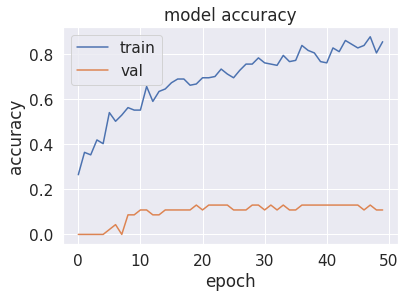

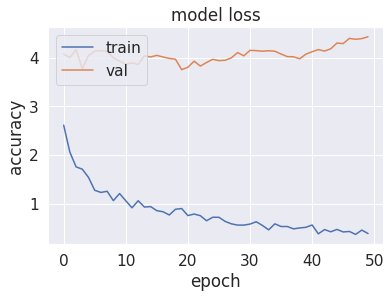

In [246]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("vision transfromer/new_dense/VIT 5_0-001lrclass .png")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("vision transfromer/new_dense/VIT 5_0-001class loss.png")
plt.show()

In [248]:
trained_model.save("vision transfromer/new_dense/vit_sgd_73.h5")

Test video path: मंगलवार्/mangalbaar (23).mp4
1/1 [==============================] - 0s 155ms/step
  मंगलवार्: 68.94%
  सोमबार: 18.01%
  शुक्रबार्:  9.74%
  चक्लेत्:  2.31%
  मेरो:  1.00%



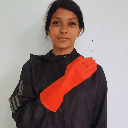

In [249]:
def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate((frames, padding))

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("dataset", path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]
#     print(f"Predicted label: {class_vocab[np.argmax(probabilities)]}: {probabilities[np.argmax(probabilities)] * 100:5.2f}")


    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames, class_vocab[np.argmax(probabilities)] 


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)[0]
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [250]:
def check_res(video_file):
    frames = predict_action(video_file)
    print(video_file,frames[1])
    
    return frames[1]

In [ ]:
test['predicted'] = test['video_name'].apply(check_res)

1/1 [==============================] - 0s 14ms/step
  चक्लेत्: 88.39%
  शुक्रबार्:  5.93%
  मंगलवार्:  2.68%
  सोमबार:  2.66%
  मेरो:  0.34%
चक्लेत्/chocolate (39).mp4 चक्लेत्
1/1 [==============================] - 0s 14ms/step
  चक्लेत्: 93.34%
  मंगलवार्:  2.65%
  सोमबार:  2.10%
  शुक्रबार्:  1.79%
  मेरो:  0.13%
चक्लेत्/chocolate (6).mp4 चक्लेत्
1/1 [==============================] - 0s 17ms/step
  चक्लेत्: 72.17%
  मंगलवार्: 10.54%
  शुक्रबार्:  9.76%
  सोमबार:  7.09%
  मेरो:  0.44%
चक्लेत्/chocolate (2).mp4 चक्लेत्
1/1 [==============================] - 0s 15ms/step
  चक्लेत्: 97.00%
  मंगलवार्:  1.06%
  शुक्रबार्:  0.99%
  सोमबार:  0.78%
  मेरो:  0.16%
चक्लेत्/chocolate (32).mp4 चक्लेत्
1/1 [==============================] - 0s 14ms/step
  चक्लेत्: 89.27%
  मंगलवार्:  6.52%
  सोमबार:  2.31%
  शुक्रबार्:  1.46%
  मेरो:  0.44%
चक्लेत्/chocolate (12).mp4 चक्लेत्
1/1 [==============================] - 0s 15ms/step
  चक्लेत्: 96.55%
  मंगलवार्:  1.55%
  सोमबार:  0.91%
  शुक्रबार्:  0.

In [189]:
from sklearn.metrics import confusion_matrix, classification_report

In [191]:
report = classification_report(test["tag"],test["predicted"])
print(report)

              precision    recall  f1-score   support

     चक्लेत्       0.75      0.27      0.40        11
    मंगलवार्       0.50      0.12      0.20         8
        मेरो       0.00      0.00      0.00         8
   शुक्रबार्       0.83      0.45      0.59        11
      सोमबार       0.30      1.00      0.46        11

    accuracy                           0.41        49
   macro avg       0.48      0.37      0.33        49
weighted avg       0.50      0.41      0.36        49



/media/gpu/157/hand_sign/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/gpu/157/hand_sign/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/gpu/157/hand_sign/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [193]:
confusion_matrix = confusion_matrix(test["tag"],test["predicted"])

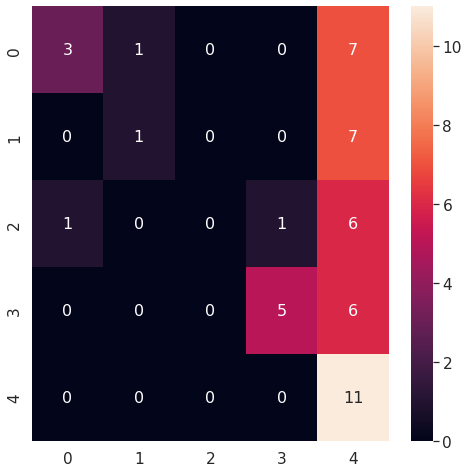

In [196]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix, range(5), range(5))
plt.figure(figsize=(8,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.savefig("vision transfromer/vit 5 epoch.png")
plt.show()